## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# Import:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time
import numpy as np
import matplotlib.pyplot as plt

# Network Implementation
from models import KeyPointNetCNN as Net
#from models import NetTiny as Net

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# Utilise GPU if available:
if  torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print('Training on GPU:',torch.cuda.get_device_name())
else:
    dtype = torch.FloatTensor
    print('Training on CPU ...')
    

Training on GPU: Tesla V100-SXM2-16GB


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Dataset and Transform for data processing:
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# Compose data transform:
data_transform = transforms.Compose([Rescale((250,250)),
                                     RandomCrop(200),
                                     Rescale((250,250)),
                                     Normalize(),
                                     ToTensor()])

# Transform needs to be defined:
assert(data_transform is not None), 'Define a data_transform'


In [4]:
# Create the transformed dataset:
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv', 
                                             root_dir='data/training/', 
                                             transform=data_transform)

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv', 
                                      root_dir='data/test/', 
                                      transform=data_transform)

# Get Stats about the some of the samples:
print('Number of images: ', len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    

Number of images:  3462
0 torch.Size([1, 250, 250]) torch.Size([68, 2])
1 torch.Size([1, 250, 250]) torch.Size([68, 2])
2 torch.Size([1, 250, 250]) torch.Size([68, 2])
3 torch.Size([1, 250, 250]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test and train dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [5]:
batch_size = 32

# Load train and test data in batches:
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size, 
                          shuffle=True,  
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=0)


In [6]:
# Instantiate Network, Loss and Optimiser:
net = Net()


## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [7]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # convert images to FloatTensors
        images = images.type(dtype)

        # forward pass to get net output
        if dtype == torch.cuda.FloatTensor:
            net.cuda()

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [8]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 250, 250])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

In [9]:
def show_all_keypoints(ax, image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    ax.imshow(image, cmap='gray')
    ax.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='g')
    # plot ground truth points as green pts
    if gt_pts is not None:
        ax.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='r')
        
        
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    """Visualise the output:"""
    
    fig = plt.figure(figsize=(20,10))
    for i in range(batch_size):
        ax = fig.add_subplot(2, batch_size/2, i+1)

        # un-transform the image data
        image = test_images[i].data              # get the image from it's wrapper        
        image = image.numpy()                    # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(ax, np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    

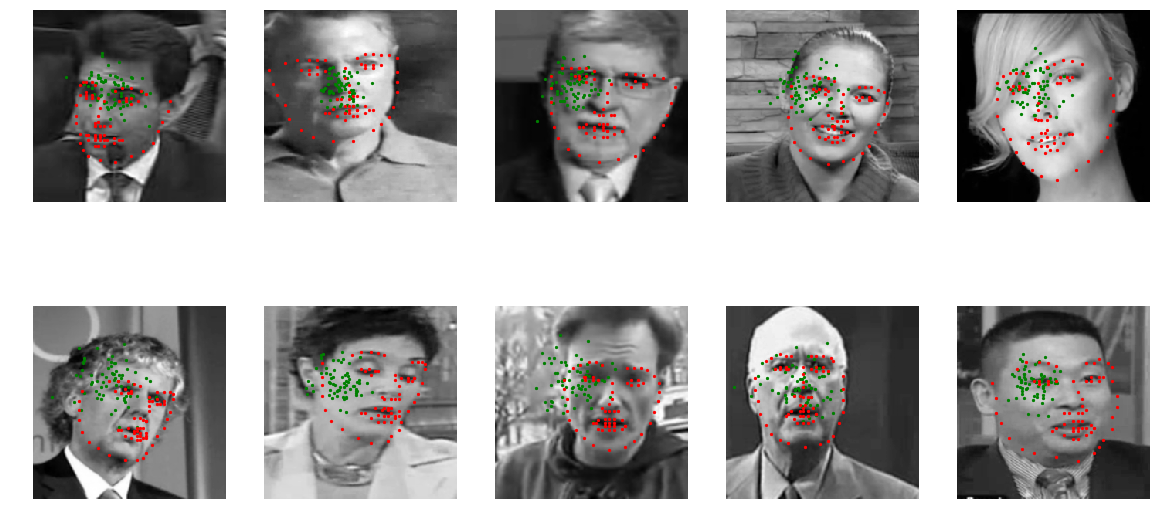

In [10]:
# Coppy data to CPU and call visualize_output:
if dtype == torch.cuda.FloatTensor:
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()
    
visualize_output(test_images, test_outputs, gt_pts)


## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [11]:
# Instantiate Network, Loss and Optimiser:
criterion = nn.MSELoss()
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

# Print network stats:
print(net)

KeyPointNetCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(6528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(1088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16224, out_features=6528, bias=True)
  (fc2): Linear(in_features=6528, out_features=1088, bias=True)
  (fc3): Linear(in_features=1088, out_features=1

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [12]:
import datetime
import time
import os 


class Trainer:
    """ Trainer class"""
    
    def __init__(self, network, optimizer, criterion, train_loader, config):
        self.train_loader = train_loader
        
        self.net = network
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.config = config
        self.internalConfig = {"epoch":0,
                               "epoch_time": [],
                               "epoch_loss":[],
                               "batch_loss":[],
                               "print_batch_and_save_loss": False,
                               "print_and_store_every": 100
                              }

    def batchTrain(self):
        """ Training loop for single epoch"""
        epoch = self.internalConfig["epoch"]
        print_batch_and_save_loss = self.internalConfig["print_batch_and_save_loss"]
        print_and_store_every = self.internalConfig["print_and_store_every"]

        loss_batch = 0.0
        epoch_tic = time.time()

        for batch_i, data in enumerate(self.train_loader):
            batch_tic = time.time()  # start timer  

            images = data['image']                                      # split data
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0), -1)                 # flatten pts
            key_pts = key_pts.type(dtype)   # convert to CUDA if GPU available:
            images = images.type(dtype)

            self.optimizer.zero_grad()                    # zero the parameter (weight) gradients
            output_pts = self.net(images)                 # forward pass to get outputs
            loss = self.criterion(output_pts, key_pts)    # calculate the loss between predicted and target keypoints
            loss.backward()                               # backward pass to calculate the weight gradients
            self.optimizer.step()                         # update the weights

            loss_batch += loss.item()

            # Get batch time:
            batch_time = time.time() - batch_tic

            # Print info if requested:
            if self.internalConfig["print_batch_and_save_loss"] and (batch_i > 0) and (batch_i % self.internalConfig["print_and_store_every"] == 0):
                print('Epoch: {},\t Batch: {},\t Batch Loss: {:.6f},\t Time: {:.3f}'.format(epoch, batch_i, loss_batch/batch_i, batch_time))
                self.internalConfig["batch_loss"].append(loss_batch/batch_i)

        # Log Data
        self.internalConfig["epoch_time"].append(time.time() - epoch_tic)
        self.internalConfig["epoch_loss"].append(loss_batch/batch_i)
        
        # Save the model if required:
        if (epoch % self.config["save_every"] == 0) or (epoch == (self.config["epochs"]-1)):
            self.saveModel(epoch)
                


    def trainPrinter(self):
        """ Training progress printer"""
        epoch_loss = self.internalConfig["epoch_loss"][-1]
        epoch_time = self.internalConfig["epoch_time"][-1]
        epoch = self.internalConfig["epoch"]
        print('Epoch: {},\t -----: ---,\t Epoch Loss: {:.6f},\t Time: {:.3f}'.format(epoch, epoch_loss, epoch_time))

    
    def saveModel(self, epoch, name = ""):
        """ save model"""
        path = self.config["model_save_path"]
        
        #Validate path:
        if len(path) > 0:
            if not os.path.exists(path): 
                os.mkdir(path)

        #Generate Unique Name 
        if not (len(name) > 0):
            now = datetime.datetime.now()
            time = now.strftime("_%y%m%d_%H%M%S")
            name = self.config["model_name"] + "_Epoch_" + str(epoch) + time + ".pt"

        torch.save(net.state_dict(), os.path.join(path,name))
        
        
    def saveData(self):
        data = {"epoch_time":self.internalConfig["epoch_time"],
                "epoch_loss":self.internalConfig["epoch_loss"],
                "batch_loss":self.internalConfig["batch_loss"]
               }
        return self.net, data
    
    
    def train(self):
        for epoch in range(self.config["epochs"]):
            self.internalConfig["epoch"] = epoch
            self.batchTrain()
            self.trainPrinter()
                
        return self.saveData()
        

        

In [13]:
config = {"epochs": 200,
          "save_every": 10,
          "model_save_path": "saved_models",
          "model_name": "KeyPointNetCNN"}

t = Trainer(net, optimizer, criterion, train_loader, config)
model, data = t.train()

Epoch: 0,	 -----: ---,	 Epoch Loss: 0.222164,	 Time: 21.051
Epoch: 1,	 -----: ---,	 Epoch Loss: 0.125790,	 Time: 21.030
Epoch: 2,	 -----: ---,	 Epoch Loss: 0.107640,	 Time: 21.228
Epoch: 3,	 -----: ---,	 Epoch Loss: 0.089230,	 Time: 20.983
Epoch: 4,	 -----: ---,	 Epoch Loss: 0.080596,	 Time: 21.029
Epoch: 5,	 -----: ---,	 Epoch Loss: 0.075059,	 Time: 20.971
Epoch: 6,	 -----: ---,	 Epoch Loss: 0.065335,	 Time: 21.097
Epoch: 7,	 -----: ---,	 Epoch Loss: 0.053679,	 Time: 21.000
Epoch: 8,	 -----: ---,	 Epoch Loss: 0.052543,	 Time: 20.984
Epoch: 9,	 -----: ---,	 Epoch Loss: 0.051104,	 Time: 21.284
Epoch: 10,	 -----: ---,	 Epoch Loss: 0.054294,	 Time: 21.009
Epoch: 11,	 -----: ---,	 Epoch Loss: 0.052323,	 Time: 21.015
Epoch: 12,	 -----: ---,	 Epoch Loss: 0.044057,	 Time: 20.990
Epoch: 13,	 -----: ---,	 Epoch Loss: 0.040675,	 Time: 21.128
Epoch: 14,	 -----: ---,	 Epoch Loss: 0.040118,	 Time: 21.028
Epoch: 15,	 -----: ---,	 Epoch Loss: 0.036292,	 Time: 21.022
Epoch: 16,	 -----: ---,	 Epoch Los

Epoch: 134,	 -----: ---,	 Epoch Loss: 0.012692,	 Time: 20.996
Epoch: 135,	 -----: ---,	 Epoch Loss: 0.011887,	 Time: 20.956
Epoch: 136,	 -----: ---,	 Epoch Loss: 0.012202,	 Time: 20.914
Epoch: 137,	 -----: ---,	 Epoch Loss: 0.012197,	 Time: 20.859
Epoch: 138,	 -----: ---,	 Epoch Loss: 0.011838,	 Time: 20.988
Epoch: 139,	 -----: ---,	 Epoch Loss: 0.012312,	 Time: 20.960
Epoch: 140,	 -----: ---,	 Epoch Loss: 0.011499,	 Time: 20.989
Epoch: 141,	 -----: ---,	 Epoch Loss: 0.011245,	 Time: 20.878
Epoch: 142,	 -----: ---,	 Epoch Loss: 0.011296,	 Time: 20.951
Epoch: 143,	 -----: ---,	 Epoch Loss: 0.010636,	 Time: 20.850
Epoch: 144,	 -----: ---,	 Epoch Loss: 0.010719,	 Time: 20.946
Epoch: 145,	 -----: ---,	 Epoch Loss: 0.012205,	 Time: 20.951
Epoch: 146,	 -----: ---,	 Epoch Loss: 0.011540,	 Time: 20.884
Epoch: 147,	 -----: ---,	 Epoch Loss: 0.011188,	 Time: 20.979
Epoch: 148,	 -----: ---,	 Epoch Loss: 0.011968,	 Time: 20.886
Epoch: 149,	 -----: ---,	 Epoch Loss: 0.010995,	 Time: 20.851
Epoch: 1

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [34]:
#Get a sample of test data:
net = model

test_images, test_outputs, gt_pts = net_sample_output()

if dtype == torch.cuda.FloatTensor:
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()
    
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())


torch.Size([32, 1, 250, 250])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


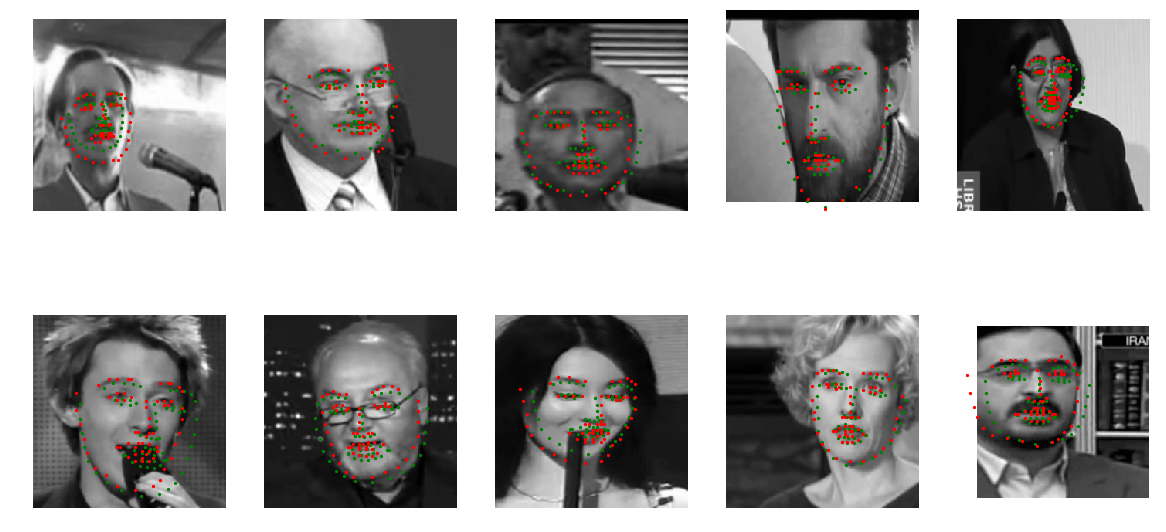

In [35]:
visualize_output(test_images, test_outputs, gt_pts)

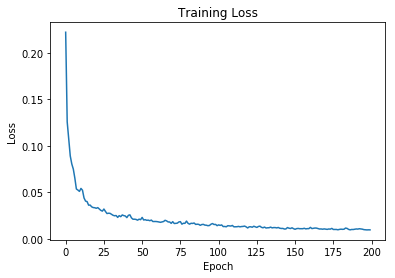

In [37]:
import matplotlib.pyplot as plt 

plt.plot(data["epoch_loss"])

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show();

Once you've found a good model (or two), save your model so you can load it and use it later!

In [24]:
## TODO: change the name to something uniqe for each new model
#model_dir = 'saved_models/'
#model_name = 'keypoints_model_333.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)


In [25]:
# Loading the model
#net.load_state_dict(torch.load('./saved_models/keypoints_model_333.pt'))


After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.00322075 -0.21406014 -0.10191269 -0.03932814  0.01325764]
 [-0.24624969 -0.06318057  0.07549927 -0.11261947  0.08888723]
 [-0.07067871 -0.09067215 -0.03080692 -0.01347575  0.0347987 ]
 [ 0.08010135 -0.18516451  0.12631421 -0.03126834  0.25626513]
 [-0.11846682  0.12244977  0.09135721  0.00648388  0.31184795]]
(5, 5)


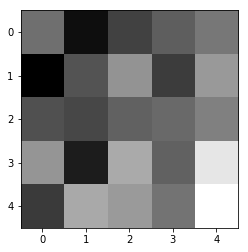

In [39]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer

net_cpu = net.cpu()
weights1 = net_cpu.conv1.weight.data

w = weights1.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

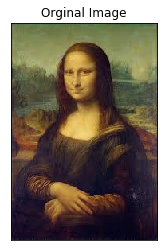

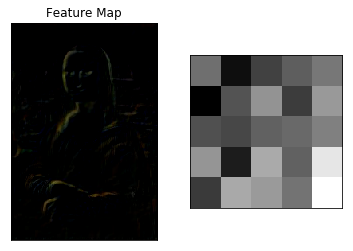

In [40]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

# Loading the image
image = cv2.imread('./images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

# Applying the image
filtered = cv2.filter2D(image, -1, w[filter_index][0])

# Visualization
fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()


---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!